In [1]:
import numpy as np
%pylab inline

pylab.rcParams['figure.figsize'] = (5.0, 5.0)

import pylab
import random
import math
import pandas
import pyproj
import gc



def load_data(path, normalize_columns = False, only_columns_containing = ""):
    print("loading...")
    gc.collect() # collect garbage
    data = pandas.read_hdf(path, '/df')
    df = pandas.DataFrame(data)
    df = df.sort(['hcad']).fillna(0)
    df = df.reset_index()#(ascending=True)

    data_dict = {}
    for label in set(df._get_numeric_data().columns).union({'hcad'}):
        # union hcad to ensure that hcad col comes in even if not considered numerical
        if normalize_columns and  label != 'hcad':
            column_data = np.array(df[label].astype(float))
            column_data -= np.min(column_data)
            data_dict[label] = column_data / np.max(column_data)
        else:
            data_dict[label] = df[label].astype(float)

        result = pandas.DataFrame.from_dict(data_dict)

    result = result.replace([np.inf, -np.inf], 1)
    
    
    for label in result:
        if not only_columns_containing in str(label):
            result.drop([str(label)], axis = 1 , inplace= True)
    return result


meta = load_data("/home/isaac/Dropbox/data_for_brian/meta/df_meta.hd")
y_data = load_data("/home/isaac/Dropbox/data_for_brian/y_df.hd")



/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib
loading...
Opening /home/isaac/Dropbox/data_for_brian/meta/df_meta.hd in read-only mode
loading...
Opening /home/isaac/Dropbox/data_for_brian/y_df.hd in read-only mode


In [2]:
wgs84=pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by GPS units and Google Earth
UTM26N=pyproj.Proj("+init=EPSG:2278") # UTM coords, zone Texas Central, WGS84 datum




In [3]:
from scipy.spatial import KDTree

In [4]:
x_values_damaged = []
y_values_damaged = []
x_values_undamaged = []
y_values_undamaged = []

ytemp = np.array(y_data['y'])

for i in range(len(meta)):
    x, y = pyproj.transform(wgs84, UTM26N, meta['lon'][i], meta['lat'][i]) ## xx, yy in meters
    if(ytemp[i] == 1):
        x_values_damaged.append(x)
        y_values_damaged.append(y)
    else:
        x_values_undamaged.append(x)
        y_values_undamaged.append(y)
damaged_locations = np.array(zip(x_values_damaged, y_values_damaged))
undamaged_locations = np.array(zip(x_values_undamaged, y_values_undamaged))

In [5]:
damaged_tree = KDTree(damaged_locations)
undamaged_tree = KDTree(undamaged_locations)

870476


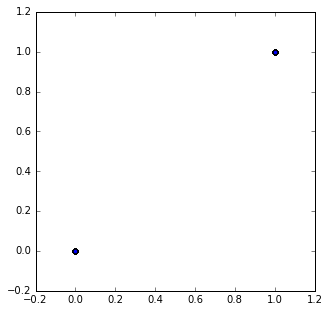

In [6]:
print len(damaged_locations) + len(undamaged_locations)
plt.scatter(ytemp, y_data['y'])
plt.show()

In [10]:
print meta

            hcad  img0  img1   index        lat        lon   pointx    pointy
0   1.000020e+12     0     0  593569  29.761900 -95.612801  3043010  13840100
1   1.000020e+12     0     0  593570  29.762100 -95.612801  3043030  13840200
2   1.000020e+12     0     0  593571  29.762300 -95.612801  3043030  13840300
3   1.000020e+12     0     0  593572  29.762501 -95.612701  3043040  13840300
4   1.000020e+12     0     0  261061  29.762699 -95.612701  3043040  13840400
5   1.000020e+12     0     0  261091  29.762899 -95.612701  3043030  13840500
6   1.000020e+12     0     0  593575  29.763100 -95.612701  3043030  13840600
7   1.000020e+12     0     0  144379  29.763300 -95.612701  3043030  13840700
8   1.000020e+12     0     0  593577  29.763500 -95.612701  3043020  13840700
9   1.000020e+12     0     0  593578  29.763700 -95.612701  3043020  13840800
10  1.000020e+12     0     0  593579  29.763901 -95.612801  3043010  13840900
11  1.000020e+12     0     0  593580  29.764099 -95.612801  3043

In [24]:

house_values = np.zeros([len(meta)])
print house_values.shape
assert len(house_values) == len(y_data['y'])
sigma = 120
 
for i in range(len(meta)):
    if i % 50000 == 0:
        print i
    x1, y1 = pyproj.transform(wgs84, UTM26N, meta['lon'][i], meta['lat'][i]) ## xx, yy in meters
    
    
    damaged_points = damaged_tree.query_ball_point([x1,y1], 70)

    house_values[i] = int(len(damaged_points) > 1)
print house_values

(870476,)
0
50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000
600000
650000
700000
750000
800000
850000
[ 0.  1.  1. ...,  0.  0.  0.]


In [79]:
# house_values = np.zeros([len(meta)])
# sigma = 150

# for i in range(500):
#     if i % 100 == 0:
#         print i
#     x1, y1 = pyproj.transform(wgs84, UTM26N, meta['lon'][i], meta['lat'][i]) ## xx, yy in meters
    
#     damaged_points =     damaged_tree.query_ball_point([x1,y1], 1000)
#     undamaged_points = undamaged_tree.query_ball_point([x1,y1], 1000)
#     total = 0.0001
#     for j in damaged_points:
#         x2, y2 = damaged_locations[j] ## xx, yy in meters
#         dist = np.sqrt((x1-x2)**2 + (y1-y2)**2)
#         gauss = 1/(2*math.sqrt(math.pi*(sigma**2))) * math.e**(-((dist)**2)/(2*sigma**2))
#         #print dist, gauss
#         house_values[i] += gauss

#         total += gauss
#     for j in undamaged_points:
#         x2, y2 = undamaged_locations[j] ## xx, yy in meters
#         dist = np.sqrt((x1-x2)**2 + (y1-y2)**2)
#         gauss = 1/(2*math.sqrt(math.pi*(sigma**2))) * math.e**(-((dist)**2)/(2*sigma**2))
# #         print dist, gauss

#         total += gauss
        
#     house_values[i] /= total
#     #print house_values[i]    
        
# print house_values

0
100
200
300
400
[ 0.32592132  0.01720933  0.35653749 ...,  0.          0.          0.        ]


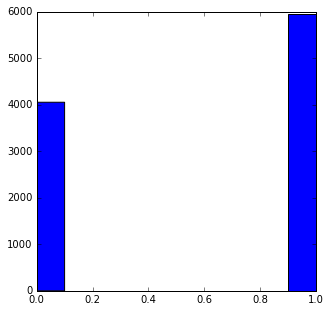

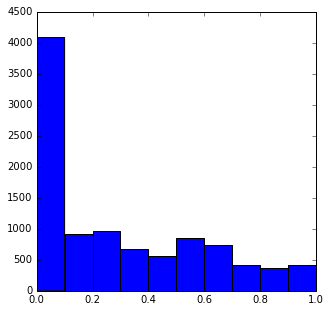

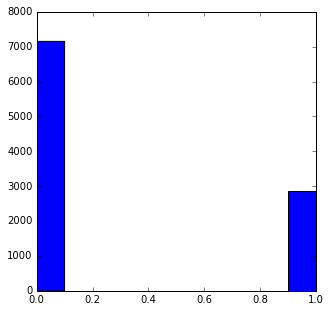

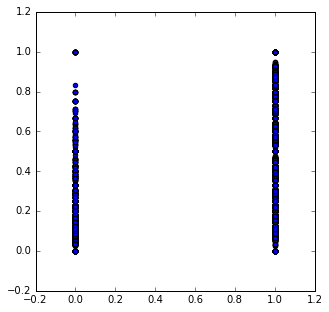

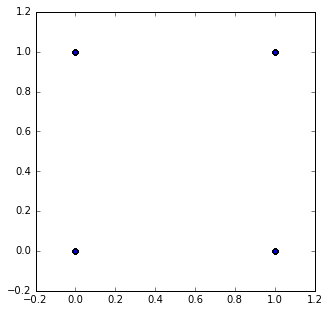

In [22]:
sample_size = 10000
plt.hist(house_values[:sample_size], bins = 10)
plt.show()
plt.hist(y_data['y200_mean'][:sample_size], bins = 10)
plt.show()

plt.hist(y_data['y'][:sample_size], bins = 10)
plt.show()

plt.scatter(house_values[:sample_size], y_data['y200_mean'][:sample_size])
plt.show()


plt.scatter(house_values[:sample_size], y_data['y'][:sample_size])
plt.show()

In [62]:
dist = 500
1000/(2*math.sqrt(math.pi*(sigma**2))) * math.e**(-((dist)**2)/(2*sigma**2))

0.02583373169261508

In [26]:
import pickle


pickle.dump( house_values, open( "/home/isaac/Desktop/house_y_classificaiton_70m_min_neighbors.p", "wb" ) )

In [23]:
house_values = pickle.load(open( "/home/isaac/Desktop/house_guassian_damage_balance.p", "rb" ) )

In [14]:
execfile( "./helpers.py")

helpers executed


In [15]:
print 1.0*len(house_values[house_values > 0]) / len(house_values)
print 1.0*len(y_data['y200_mean'][y_data['y200_mean'] > 0]) / len(y_data['y200_mean'])
print 1.0*len(y_data['y'][y_data['y'] > 0]) / len(y_data['y'])

0.894202712079
0.519665102771
0.195302340329


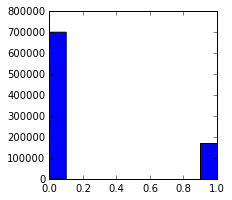

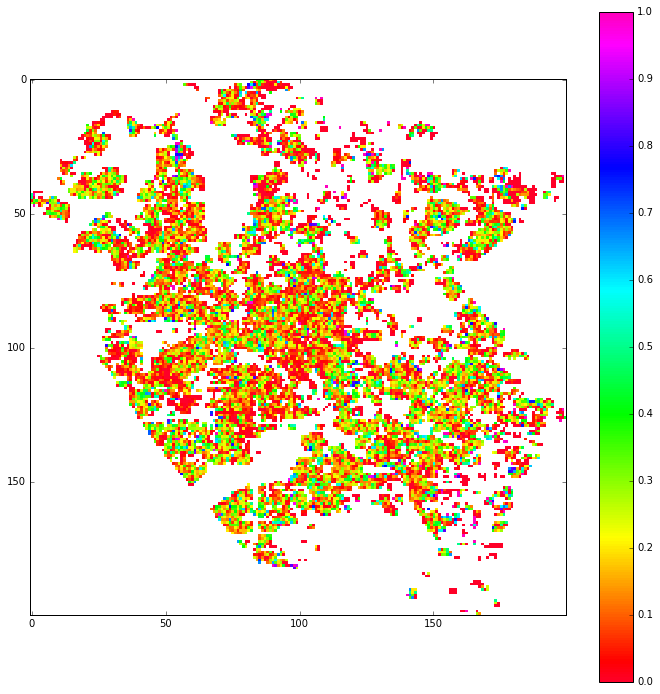

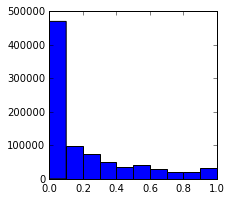

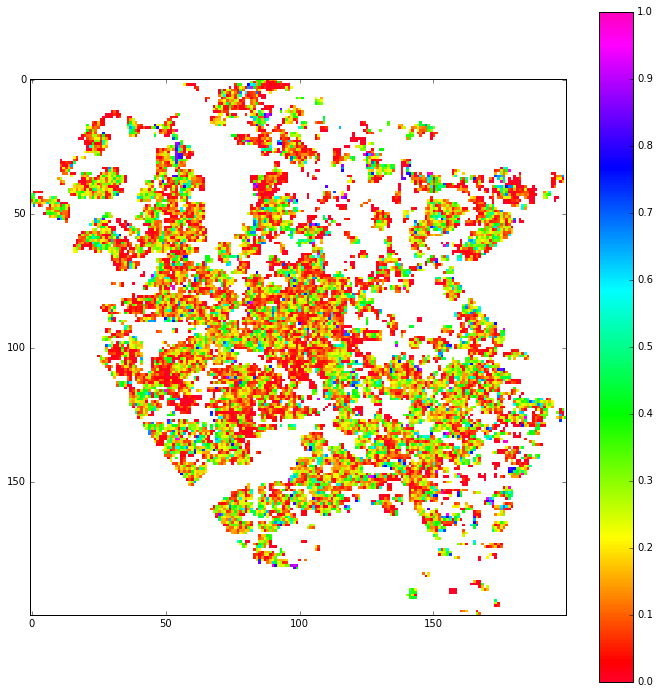

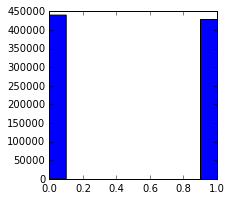

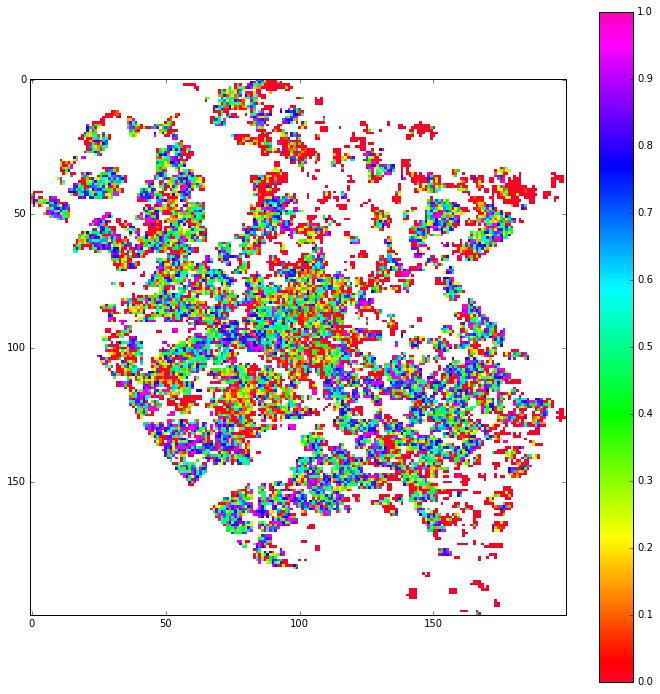

In [25]:
from collections import defaultdict


def old_fast_show_ratio_plot(xy_points, y_data, log = False, normalize_buckets=True):
    if log:
        y_data = np.log(y_data)
    fig = plt.figure(frameon=False)
    fig.set_size_inches(3,3)
    plt.hist(y_data)
    plt.show()

    buckets = defaultdict(list)
    resolution = 200
    x = np.array(xy_points['x'])
    y = np.array(xy_points['y'])
    H, xedges, yedges = numpy.histogram2d(x,y, bins=resolution, weights = y_data)
    H_nums, dummy2, dummy1 = numpy.histogram2d(x,y, bins=resolution)
    plt.show()
    fig = plt.figure(frameon=False)
    fig.set_size_inches(12,12)
    if normalize_buckets:
        H=H/H_nums
    H[H_nums == 0.0] = numpy.nan
#     if log:
#         H = np.log(H)
    

    plt.imshow(H, 
               interpolation='nearest', cmap=cm.gist_rainbow)
    plt.colorbar()
    plt.show()
    return np.nan_to_num(H)


META = meta

def plot_on_map(pddf, meta = META):
    for col in pddf.columns:
        xy = pandas.DataFrame.from_dict({'x': -meta['pointx'],'y': meta['pointy']})
        old_fast_show_ratio_plot(xy,np.array(pddf[col]))
        
plot_on_map(pandas.DataFrame.from_dict({"x": y_data['y']}))
plot_on_map(pandas.DataFrame.from_dict({"x": y_data['y200_mean']}))
plot_on_map(pandas.DataFrame.from_dict({"x": house_values}))